In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pyei.r_by_c import RowByColumnEI
from pyei.data import get_data

# Demo of RxC models and plotting using Santa Clara data

We show examples of using and examining models available in pyei using a sample data set:

In [2]:
data = get_data("santaClara.csv")

precinct_pops = np.array(data['total2'])
votes_fractions = np.array(data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
candidate_names = ["Hardy", "Kolstad", "Nadeem"]
group_fractions = np.array(data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
demographic_group_names = ["ind", "e_asian", "non_asian"]


In [3]:
ei = RowByColumnEI(model_name='multinomial-dirichlet-modified')

In [4]:
ei.fit(group_fractions, votes_fractions, precinct_pops, demographic_group_names, candidate_names)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi, kappa]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Plotting

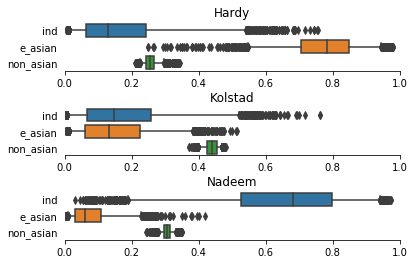

In [5]:
ei.plot_boxplots()

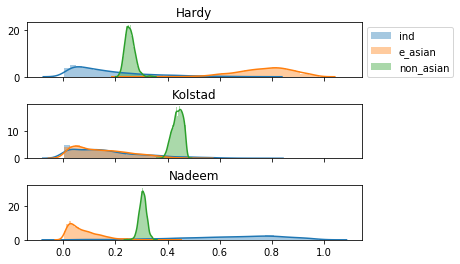

In [6]:
ei.plot_kdes(plot_by="candidate")

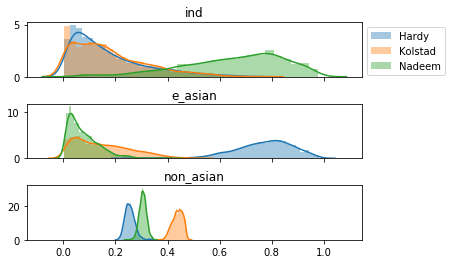

In [7]:
ei.plot_kdes(plot_by="group")

## Summaries
Text summaries and summary statistics

In [8]:
print(ei.summary())


            Computed from the raw b_ samples by multiplying by population and then 
            getting the proportion of the total pop 
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                ind for Hardy is
                0.172
                Credible interval:  [0.01410929 0.54058299]
                The posterior mean for the district-level voting preference of
                ind for Kolstad is
                0.177
                Credible interval:  [0.00663826 0.52180036]
                The posterior mean for the district-level voting preference of
                ind for Nadeem is
                0.651
                Credible interval:  [0.19044495 0.9404315 ]
                The posterior mean for the district-level voting preference of
                e_asian for Hardy is
                0.772
                Credible interval:  [0.54693138 0.94596247]
                The posterior 

In [9]:
print(ei.candidate_of_choice())

ind
In 0.07525 of samples, the district-level vote preference of
                    ind for Hardy
                    was higher than for any other candidate
In 0.06175 of samples, the district-level vote preference of
                    ind for Kolstad
                    was higher than for any other candidate
In 0.863 of samples, the district-level vote preference of
                    ind for Nadeem
                    was higher than for any other candidate
e_asian
In 0.9935 of samples, the district-level vote preference of
                    e_asian for Hardy
                    was higher than for any other candidate
In 0.00525 of samples, the district-level vote preference of
                    e_asian for Kolstad
                    was higher than for any other candidate
In 0.00125 of samples, the district-level vote preference of
                    e_asian for Nadeem
                    was higher than for any other candidate
non_asian
In 0.0 of samples, the district-l

### Posterior means of voting preference for each group/candidate:

In [10]:
posterior_mean_voting_prefs = ei.posterior_mean_voting_prefs
df = pd.DataFrame(posterior_mean_voting_prefs, columns=candidate_names, index=demographic_group_names)
df.head()

,Hardy,Kolstad,Nadeem
ind,0.171741,0.177405,0.650854
e_asian,0.771636,0.151328,0.077036
non_asian,0.255768,0.438785,0.305447


### 95% Credible interval for voting preferences for each group:

In [11]:
num_groups, num_candidates = ei.num_groups_and_num_candidates # R, C
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
for r in range(num_groups):
    for c in range(num_candidates):
        print(demographic_group_names[r],candidate_names[c], credible_interval_95_mean_voting_prefs[r][c])

ind Hardy [0.01410929 0.54058299]
ind Kolstad [0.00663826 0.52180036]
ind Nadeem [0.19044495 0.9404315 ]
e_asian Hardy [0.54693138 0.94596247]
e_asian Kolstad [0.01251979 0.38198278]
e_asian Nadeem [0.00885123 0.22771375]
non_asian Hardy [0.22425115 0.29669351]
non_asian Kolstad [0.39856787 0.47007183]
non_asian Nadeem [0.27775117 0.33341799]


## Samples

Samples from the posterior are accessible. 

Precinct level samples are aggregated into district level preference samples by weighting each precinct by its population:

In [12]:
ei.sampled_voting_prefs.shape # ei.sampled_voting_prefs is samples of district-level voter preference: num_samples x r x c

(4000, 3, 3)

Samples can also be obtained directly by the parameter name in the model:

In [13]:
ei.sim_trace["b"].shape # ei.sim_trace["b"] is samples of precinct-level voter preference: num_samples x num_precincts x r x c

(4000, 42, 3, 3)

In [14]:
ei.sim_trace["kappa"].mean()

56.62655864085346

### Accessing (and visualizing) the pymc model

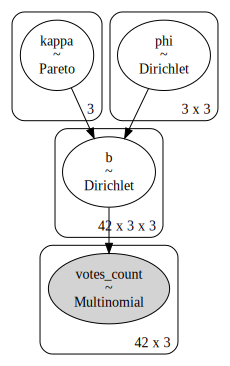

In [15]:
model = ei.sim_model
pm.model_to_graphviz(model)